In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", False)
from sklearn.metrics import mean_absolute_percentage_error
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

2022-09-19 13:35:02.182056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 13:35:02.182078: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Prepare dataset

## Load data

In [2]:
df = pd.read_csv('data/data_preparation.csv', index_col=[0])

In [3]:
df

,Date,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,TCO Thermique (%),TCH Thermique (%),TCO Nucléaire (%),TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),Column 30,YEAR,MONTH,DAY,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS10M,WS50M,...,bank_holiday,school_holidays,season,num_day,sin365_1,cos365_1,sin365_2,cos365_2,sin365_3,cos365_3,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12,t - 13,t - 14,t - 15,t - 16,t - 17,t - 18,t - 19,t - 20,t - 21,t - 22,t - 23,t - 24,t - 25,t - 26,t - 27,t - 28,t - 29,t - 30
32,2013-02-02,4464,262321.0,15464.0,0.0,1574.0,2710.0,57188.0,0.0,3215.0,182068.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2013,2,2,5.55,2.13,3.84,5.69,7.38,8.87,1.48,4.82,79.19,1.94,95.99,12.23,15.88,...,0.0,0,1,33,0.537677,0.843151,0.906686,0.421806,0.764891,-0.644159,266134.0,268874.0,285681.0,303496.0,303546.0,298866.0,309993.0,321288.0,313799.0,314414.0,306209.0,309629.0,290859.0,325285.0,347705.0,346695.0,332304.0,326236.0,305170.0,280488.0,278107.0,280801.0,284001.0,283434.0,280984.0,270102.0,257432.0,267848.0,286799.0,285526.0
33,2013-02-03,4464,273743.0,15644.0,0.0,1273.0,3718.0,58723.0,0.0,3211.0,191068.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2013,2,3,2.96,-2.28,0.33,3.13,9.71,8.87,-0.84,3.30,69.88,0.02,97.48,9.45,12.35,...,0.0,0,1,34,0.552101,0.833777,0.920659,0.390368,0.718792,-0.695225,262321.0,266134.0,268874.0,285681.0,303496.0,303546.0,298866.0,309993.0,321288.0,313799.0,314414.0,306209.0,309629.0,290859.0,325285.0,347705.0,346695.0,332304.0,326236.0,305170.0,280488.0,278107.0,280801.0,284001.0,283434.0,280984.0,270102.0,257432.0,267848.0,286799.0
34,2013-02-04,4464,295369.0,28333.0,0.0,570.0,3381.0,78809.0,0.0,3134.0,181039.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2013,2,4,4.67,1.85,3.26,4.77,11.67,10.80,-0.88,4.52,82.94,0.00,98.21,7.31,10.12,...,0.0,0,1,35,0.566362,0.824157,0.933542,0.358468,0.669290,-0.743001,273743.0,262321.0,266134.0,268874.0,285681.0,303496.0,303546.0,298866.0,309993.0,321288.0,313799.0,314414.0,306209.0,309629.0,290859.0,325285.0,347705.0,346695.0,332304.0,326236.0,305170.0,280488.0,278107.0,280801.0,284001.0,283434.0,280984.0,270102.0,257432.0,267848.0
35,2013-02-05,4464,287424.0,38139.0,0.0,764.0,2067.0,72157.0,0.0,3162.0,171033.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2013,2,5,6.65,5.23,5.94,6.64,8.27,11.44,3.16,5.68,89.69,0.19,97.68,6.63,9.32,...,0.0,0,1,36,0.580455,0.814292,0.945320,0.326144,0.616621,-0.787260,295369.0,273743.0,262321.0,266134.0,268874.0,285681.0,303496.0,303546.0,298866.0,309993.0,321288.0,313799.0,314414.0,306209.0,309629.0,290859.0,325285.0,347705.0,346695.0,332304.0,326236.0,305170.0,280488.0,278107.0,280801.0,284001.0,283434.0,280984.0,270102.0,257432.0
36,2013-02-06,4464,294084.0,50421.0,0.0,816.0,2624.0,70043.0,0.0,3227.0,166848.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2013,2,6,2.71,0.23,1.47,2.94,7.97,6.41,-1.56,4.03,84.50,0.10,96.65,6.42,8.96,...,0.0,0,1,37,0.594376,0.804187,0.955979,0.293434,0.561034,-0.827793,287424.0,295369.0,273743.0,262321.0,266134.0,268874.0,285681.0,303496.0,303546.0,298866.0,309993.0,321288.0,313799.0,314414.0,306209.0,309629.0,290859.0,325285.0,347705.0,346695.0,332304.0,326236.0,305170.0,280488.0,278107.0,280801.0,284001.0,283434.0,280984.0,270102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3412,2022-05-11,4464,218296.0,34225.0,0.0,1909.0,10139.0,40944.0,-306.0,3115.0,128276.0,0.0,0.0,0.0,0.0

## Fill the missing data

In [4]:
def replace_val(df,date1,date2): #on remplace les NaN dans l intervalle de date
    for col in df.columns:
        imputer = KNNImputer(n_neighbors=7) # Instantiate a SimpleImputer object with your strategy of choice
        imputer.fit(df[[col]]) # Call the "fit" method on the object
        df[col] = imputer.transform(df[[col]]) # Call the "transform" method on the object

In [5]:
df['Date']=pd.to_datetime(df['Date'])
df = df.set_index('Date').asfreq('D')
replace_val(df,'2022-04-30','2022-05-06')

### Select relevant features

In [6]:
df.drop(columns=['t - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 't - 8', 't - 9', 't - 10', 't - 11', 't - 12',
       't - 13', 't - 14', 't - 15', 't - 16', 't - 17', 't - 18', 't - 19',
       't - 20', 't - 21', 't - 22', 't - 23', 't - 24', 't - 25', 't - 26',
       't - 27', 't - 28', 't - 29', 't - 30','sin365_1', 'cos365_1', 'sin365_2', 'cos365_2',
       'sin365_3', 'cos365_3','bank_holiday', 'school_holidays',
       'season','Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
       'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)',
       'Ech. physiques (MW)', 'Stockage batterie', 'Déstockage batterie',
       'Eolien terrestre', 'Eolien offshore', 'TCO Thermique (%)',
       'TCH Thermique (%)', 'TCO Nucléaire (%)', 'TCH Nucléaire (%)',
       'TCO Eolien (%)', 'TCH Eolien (%)', 'TCO Solaire (%)',
       'TCH Solaire (%)', 'Column 30','Code INSEE région','sin_month', 'cos_month',
        'num_day',
        'YEAR', 'MONTH', 'DAY',
        'T2MDEW', 'T2MWET', 'TS', 'T2M_RANGE',
       'T2M_MAX', 'T2M_MIN','PS', 'QV2M','WS10M','WS50M','RH2M','week_day' #temoin
        #'PRECTOTCORR' # PRECTOTCORR is bias-corrected total precipitation
        #'sin_day','cos_day'
                ],inplace=True)

### Look of the dataset

In [7]:
df.head()

,Consommation (MW),T2M,PRECTOTCORR,sin_day,cos_day
Date,,,,,
2013-02-02,262321.0,5.55,1.94,-0.974928,-0.222521
2013-02-03,273743.0,2.96,0.02,-0.781831,0.623490
2013-02-04,295369.0,4.67,0.00,0.000000,1.000000
2013-02-05,287424.0,6.65,0.19,0.781831,0.623490
2013-02-06,294084.0,2.71,0.10,0.974928,-0.222521


# Compute energy consumption

## Fonction history (deep learning)

In [8]:
def plot_loss_mape(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    #ax1.set_ylim(ymin=0, ymax=10000)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['mape'])
    ax2.plot(history.history['val_mape'])
    ax2.set_title('MAPE')
    ax2.set_ylabel('MAPE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=5)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()

## Definition of the compute function

In [9]:
def build_X_y(df_base,N_reg):
    df_modified = df_base.copy()
    
    for i in range(1, N_reg+1):
        df_modified[f't - {i}'] = df_base['Consommation (MW)'].shift(i)
        
    X = df_modified.drop(columns='Consommation (MW)').iloc[N_reg:] #retrait des NaN
    y = df_modified['Consommation (MW)'].iloc[N_reg:] #retrait des NaN
    
    return X,y
    

In [10]:
def train_model(df_base,estimator,N_reg,p_train=0.85):
    
    df_model = df_base.copy()
    
    for i in range(1, N_reg+1):
        df_model[f't - {i}'] = df_base['Consommation (MW)'].shift(i)
    
    N_data = len(df) # On va faire l entrainement seulement sur 85% des data pour pouvoir ensuite le tester arbitrairement
    N_train = int(N_data*p_train) #Ne pas faire démarer le test avant le 19 décembre 2020 pour ne pas biaiser le résultat
    df_train = df_model.iloc[:N_train]
    y_train = df_train['Consommation (MW)']
    
    X_train = df_train.drop(columns='Consommation (MW)').iloc[N_reg:] #retrait des NaN
    y_train=df_train['Consommation (MW)'].iloc[N_reg:] #retrait des NaN
    
    model_trained = estimator.fit(X_train, y_train)
    
    return model_trained, df_model

In [11]:
def compute_energy_forecast(df_model, Date_start_test, N_test, N_reg, model_trained):
    
    #df_model = df_model.copy()
    
    Date_start_test = pd.to_datetime(Date_start_test)
    Date_fin_test =  Date_start_test + timedelta(days=N_test-1)
    
    if len(df_model.loc[df_model.index == Date_fin_test]) == 0:
        date_max=pd.to_datetime('2022-05-14')-timedelta(days=N_test-1)
        print(f'Erreur, veuillez saisir une date de début de test inférieure ou egale à : {str(date_max)}')
        return 0,0

    if len(df_model.loc[df_model.index == Date_start_test-timedelta(days=2*N_reg)]) == 0:
        date_limite_deb=pd.to_datetime('2013-03-04')+timedelta(days=2*N_reg)
        print(f'Erreur, veuillez saisir une date de début de test supérieure ou egale à : {str(date_limite_deb)}')
        return 0,0
    
    df_test = df_model.loc[(df_model.index >= Date_start_test) & (df_model.index <= Date_fin_test)]
    y_true  = df_test['Consommation (MW)']
    df_test = df_test.copy()
    
    for i in range(1, N_reg+1):
        df_test[f't - {i}'] = float('NaN')
    
    v_reg = pd.DataFrame(index=['0'])
    
    y_pred=[]

    for i in range(0,N_test):
        X_test=df_test.iloc[[i]].drop(columns='Consommation (MW)')
        if i==0:
            for j in range(1, N_reg+1):
                v_reg[f't - {j}'] = df_model.loc[Date_start_test - timedelta(days = j)][f't - {j}']
        for j in range(1, N_reg+1):
            X_test[f't - {j}'] = v_reg[f't - {j}'][0]

        out=model_trained.predict(X_test)

        y_pred.append(out[0])
        
        if N_reg > 0:
            v_reg=v_reg.shift(1,axis=1)
            v_reg.iloc[0,0]=out[0]
    
    y_pred=pd.Series(y_pred,index=y_true.index)
    
    return y_true, y_pred

## Inputs optimisés

### Choix du model et niveau d'auto-régressivité

In [134]:
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100,max_depth=3,subsample=1.0,alpha=0.9) #0.032 ok
#model = RandomForestRegressor(n_estimators=100) #0.034 ok
#model = XGBRegressor(n_estimators = 110, max_depth=3) #0.034 ok
#model = BaggingRegressor() #0.036 ok
#model = KNeighborsRegressor() #0.036 ok
#model = AdaBoostRegressor() #0.049
#model = DecisionTreeRegressor() #0.051 ok
#model = baseline #0.058 baseline ok
#model = LinearRegression() #0.067 ok
#model = SGDRegressor() #0.068 ok
#model = StackingRegressor(estimators=[('lr', RidgeCV()),('svr', LinearSVR(random_state=42))],final_estimator=RandomForestRegressor()) #0.121
#model = SVR() #0.133
N_reg=1 #Nombre de jours auto-régressifs
allow_grid_searching = 0

In [135]:
estimator = make_pipeline(StandardScaler(), model)

### Gridsearch

In [136]:
estimator.get_params() #to find the names of the params to gridsearch

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('linearregression', LinearRegression())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'linearregression': LinearRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'linearregression__copy_X': True,
 'linearregression__fit_intercept': True,
 'linearregression__n_jobs': None,
 'linearregression__normalize': 'deprecated',
 'linearregression__positive': False}

In [125]:
# GridSearch
if allow_grid_searching:
    param_grid =  {'adaboostregressor__n_estimators': list(range(10,120,10)),
                   'adaboostregressor__learning_rate': np.linspace(0.05,0.2,16)}
        
    search = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                              cv=5, n_jobs=-1, verbose=3, scoring='neg_mean_absolute_percentage_error')

    
    X_learn, y_learn = build_X_y(df,N_reg)
    search.fit(X_learn, y_learn);

    print('best_params=',search.best_params_)
    print('best score=',search.best_score_)

Fitting 5 folds for each of 176 candidates, totalling 880 fits
[CV 2/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=17;, score=-0.021 total time=   0.0s
[CV 3/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=17;, score=-0.020 total time=   0.0s
[CV 4/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=17;, score=-0.032 total time=   0.0s
[CV 5/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=17;, score=-0.020 total time=   0.0s
[CV 2/5] END kneighborsregressor__leaf_size=33, kneighborsregressor__n_neighbors=5;, score=-0.020 total time=   0.0s
[CV 3/5] END kneighborsregressor__leaf_size=33, kneighborsregressor__n_neighbors=5;, score=-0.020 total time=   0.0s
[CV 4/5] END kneighborsregressor__leaf_size=33, kneighborsregressor__n_neighbors=5;, score=-0.030 total time=   0.0s
[CV 5/5] END kneighborsregressor__leaf_size=33, kneighborsregressor__n_neighbors=5;, score=-0.021 total time=   0.

[CV 5/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=5;, score=-0.021 total time=   0.0s
[CV 1/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=7;, score=-0.021 total time=   0.0s
[CV 2/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=7;, score=-0.020 total time=   0.0s
[CV 3/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=7;, score=-0.020 total time=   0.0s
[CV 4/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=7;, score=-0.030 total time=   0.0s
[CV 5/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=7;, score=-0.020 total time=   0.0s
[CV 1/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=9;, score=-0.021 total time=   0.0s
[CV 1/5] END kneighborsregressor__leaf_size=30, kneighborsregressor__n_neighbors=17;, score=-0.022 total time=   0.0s
[CV 2/5] END kneighborsregressor__leaf_size=30, kneighborsregre

[CV 2/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=9;, score=-0.020 total time=   0.0s
[CV 3/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=9;, score=-0.019 total time=   0.0s
[CV 4/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=9;, score=-0.030 total time=   0.0s
[CV 5/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=9;, score=-0.020 total time=   0.0s
[CV 1/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=11;, score=-0.021 total time=   0.0s
[CV 2/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=11;, score=-0.020 total time=   0.0s
[CV 3/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=11;, score=-0.019 total time=   0.0s
[CV 4/5] END kneighborsregressor__leaf_size=27, kneighborsregressor__n_neighbors=11;, score=-0.030 total time=   0.0s
[CV 3/5] END kneighborsregressor__leaf_size=30, kneighborsre

[CV 1/5] END kneighborsregressor__leaf_size=30, kneighborsregressor__n_neighbors=13;, score=-0.021 total time=   0.0s
[CV 2/5] END kneighborsregressor__leaf_size=30, kneighborsregressor__n_neighbors=13;, score=-0.021 total time=   0.0s
[CV 5/5] END kneighborsregressor__leaf_size=33, kneighborsregressor__n_neighbors=7;, score=-0.020 total time=   0.0s
[CV 1/5] END kneighborsregressor__leaf_size=33, kneighborsregressor__n_neighbors=9;, score=-0.021 total time=   0.1s
[CV 2/5] END kneighborsregressor__leaf_size=33, kneighborsregressor__n_neighbors=9;, score=-0.020 total time=   0.0s
[CV 3/5] END kneighborsregressor__leaf_size=33, kneighborsregressor__n_neighbors=9;, score=-0.019 total time=   0.0s
[CV 4/5] END kneighborsregressor__leaf_size=33, kneighborsregressor__n_neighbors=9;, score=-0.030 total time=   0.0s
[CV 5/5] END kneighborsregressor__leaf_size=33, kneighborsregressor__n_neighbors=9;, score=-0.020 total time=   0.0s
[CV 1/5] END kneighborsregressor__leaf_size=33, kneighborsregr

[CV 1/5] END kneighborsregressor__leaf_size=57, kneighborsregressor__n_neighbors=5;, score=-0.021 total time=   0.0s
[CV 4/5] END kneighborsregressor__leaf_size=57, kneighborsregressor__n_neighbors=15;, score=-0.031 total time=   0.0s
[CV 2/5] END adaboostregressor__learning_rate=0.05, adaboostregressor__n_estimators=10;, score=-0.035 total time=   0.2s
[CV 2/5] END adaboostregressor__learning_rate=0.05, adaboostregressor__n_estimators=30;, score=-0.033 total time=   0.2s
[CV 3/5] END adaboostregressor__learning_rate=0.05, adaboostregressor__n_estimators=50;, score=-0.033 total time=   0.3s
[CV 4/5] END adaboostregressor__learning_rate=0.05, adaboostregressor__n_estimators=50;, score=-0.047 total time=   0.3s
[CV 4/5] END adaboostregressor__learning_rate=0.05, adaboostregressor__n_estimators=80;, score=-0.046 total time=   0.7s
[CV 5/5] END adaboostregressor__learning_rate=0.05, adaboostregressor__n_estimators=80;, score=-0.030 total time=   0.5s
[CV 2/5] END adaboostregressor__learnin

[CV 3/5] END adaboostregressor__learning_rate=0.060000000000000005, adaboostregressor__n_estimators=40;, score=-0.033 total time=   0.3s
[CV 4/5] END adaboostregressor__learning_rate=0.060000000000000005, adaboostregressor__n_estimators=40;, score=-0.046 total time=   0.2s
[CV 5/5] END adaboostregressor__learning_rate=0.060000000000000005, adaboostregressor__n_estimators=60;, score=-0.031 total time=   0.4s
[CV 1/5] END adaboostregressor__learning_rate=0.060000000000000005, adaboostregressor__n_estimators=70;, score=-0.032 total time=   0.6s
[CV 3/5] END adaboostregressor__learning_rate=0.060000000000000005, adaboostregressor__n_estimators=100;, score=-0.032 total time=   0.6s
[CV 4/5] END adaboostregressor__learning_rate=0.060000000000000005, adaboostregressor__n_estimators=100;, score=-0.044 total time=   0.6s
[CV 2/5] END adaboostregressor__learning_rate=0.07, adaboostregressor__n_estimators=40;, score=-0.033 total time=   0.3s
[CV 3/5] END adaboostregressor__learning_rate=0.07, ada

[CV 3/5] END adaboostregressor__learning_rate=0.060000000000000005, adaboostregressor__n_estimators=80;, score=-0.032 total time=   0.5s
[CV 4/5] END adaboostregressor__learning_rate=0.060000000000000005, adaboostregressor__n_estimators=80;, score=-0.046 total time=   0.5s
[CV 2/5] END adaboostregressor__learning_rate=0.060000000000000005, adaboostregressor__n_estimators=110;, score=-0.031 total time=   1.0s
[CV 3/5] END adaboostregressor__learning_rate=0.060000000000000005, adaboostregressor__n_estimators=110;, score=-0.032 total time=   0.9s
[CV 1/5] END adaboostregressor__learning_rate=0.07, adaboostregressor__n_estimators=90;, score=-0.030 total time=   0.5s
[CV 2/5] END adaboostregressor__learning_rate=0.07, adaboostregressor__n_estimators=90;, score=-0.031 total time=   0.5s
[CV 2/5] END adaboostregressor__learning_rate=0.08000000000000002, adaboostregressor__n_estimators=10;, score=-0.033 total time=   0.1s
[CV 3/5] END adaboostregressor__learning_rate=0.08000000000000002, adabo

[CV 5/5] END adaboostregressor__learning_rate=0.07, adaboostregressor__n_estimators=40;, score=-0.031 total time=   0.3s
[CV 5/5] END adaboostregressor__learning_rate=0.07, adaboostregressor__n_estimators=70;, score=-0.030 total time=   0.5s
[CV 1/5] END adaboostregressor__learning_rate=0.07, adaboostregressor__n_estimators=80;, score=-0.030 total time=   0.5s
[CV 1/5] END adaboostregressor__learning_rate=0.07, adaboostregressor__n_estimators=110;, score=-0.030 total time=   0.8s
[CV 2/5] END adaboostregressor__learning_rate=0.07, adaboostregressor__n_estimators=110;, score=-0.031 total time=   0.6s
[CV 2/5] END adaboostregressor__learning_rate=0.08000000000000002, adaboostregressor__n_estimators=70;, score=-0.031 total time=   0.4s
[CV 3/5] END adaboostregressor__learning_rate=0.08000000000000002, adaboostregressor__n_estimators=70;, score=-0.032 total time=   0.5s
[CV 3/5] END adaboostregressor__learning_rate=0.08000000000000002, adaboostregressor__n_estimators=100;, score=-0.032 tot

[CV 1/5] END adaboostregressor__learning_rate=0.11000000000000001, adaboostregressor__n_estimators=50;, score=-0.031 total time=   0.4s
[CV 2/5] END adaboostregressor__learning_rate=0.11000000000000001, adaboostregressor__n_estimators=50;, score=-0.032 total time=   0.3s
[CV 2/5] END adaboostregressor__learning_rate=0.11000000000000001, adaboostregressor__n_estimators=80;, score=-0.031 total time=   0.5s
[CV 3/5] END adaboostregressor__learning_rate=0.11000000000000001, adaboostregressor__n_estimators=80;, score=-0.031 total time=   0.5s
[CV 3/5] END adaboostregressor__learning_rate=0.11000000000000001, adaboostregressor__n_estimators=110;, score=-0.032 total time=   0.7s
[CV 4/5] END adaboostregressor__learning_rate=0.11000000000000001, adaboostregressor__n_estimators=110;, score=-0.045 total time=   0.7s
[CV 5/5] END adaboostregressor__learning_rate=0.12000000000000001, adaboostregressor__n_estimators=60;, score=-0.029 total time=   0.4s
[CV 1/5] END adaboostregressor__learning_rate=

### Learning curve

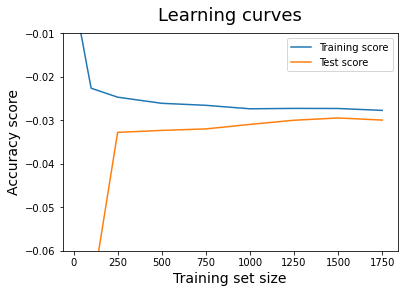

In [126]:
X_learn, y_learn = build_X_y(df,N_reg)

train_sizes = [25,50,75,100,250,500,750,1000,1250,1500,1750]
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_learn, y=y_learn, train_sizes=train_sizes, 
                                                        cv=5, scoring='neg_mean_absolute_percentage_error')

#Pour connaitre les scorer par défaut, entrer:
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys())

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
plt.ylim([-0.06, -0.01])
plt.legend()

### Fenêtre de tests

In [127]:
Date_debut_test = '2020-12-19'#Ne pas faire démarer le test avant le 19 décembre 2020 pour ne pas biaiser le résultat
N_test = 14

## Train the model

In [128]:
model, df_model = train_model(df, estimator, N_reg)

## Call of the forecast function

In [129]:
y_true, y_pred = compute_energy_forecast(df_model, Date_debut_test, N_test, N_reg, model)

## Display results for a model

MAPE_MODEL = 0.02294758149457085, MAPE_baseline = 0.09375025107081468


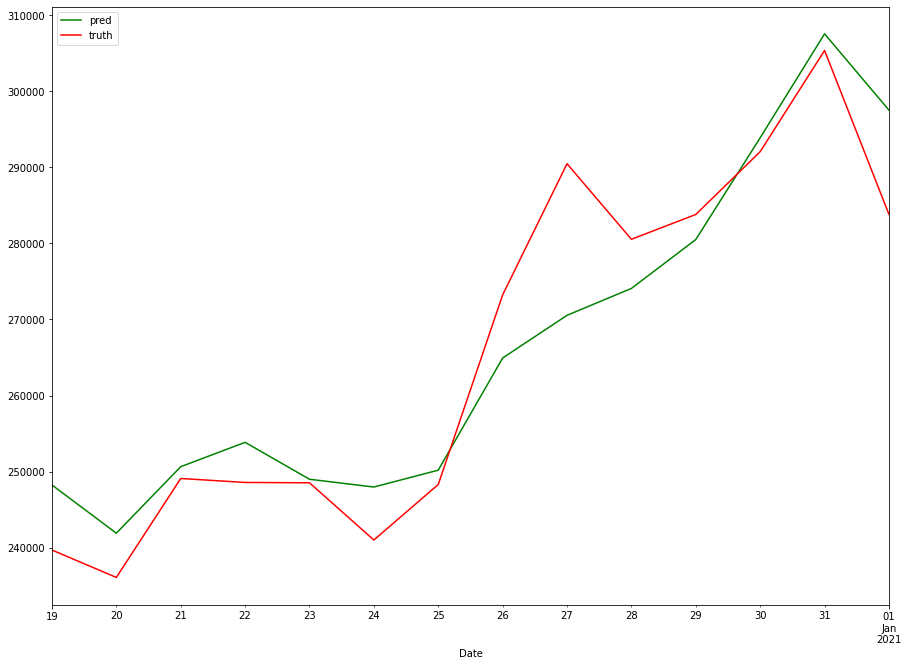

In [130]:
plt.figure(figsize=(15,11))
y_pred.plot(color = 'green',label='pred')
#y_train.plot(color = 'blue')
y_true.plot(color = 'red',label='truth')
plt.legend()
MAPE_MODEL = mean_absolute_percentage_error(y_true, y_pred) # MAE en pourcentage 
y_baseline = np.ones(N_test)*df.loc[pd.to_datetime('2020-12-19')]['Consommation (MW)']
MAPE_baseline = mean_absolute_percentage_error(y_true, y_baseline) # MAE en pourcentage
print(f'MAPE_MODEL = {MAPE_MODEL}, MAPE_baseline = {MAPE_baseline}')

## Cross-validation to select the best model

In [131]:
def mean_dict(dict_in):
    mean = 0
    i=0
    for value in dict_in.values():
        i=i+1
        mean = mean +value
    return mean/i
    

In [132]:
Date_debut_test = pd.to_datetime('2020-12-19')

dict_result_model=dict()
dict_result_baseline=dict()

for i in range(0,35):
    Date_debut_test = Date_debut_test + timedelta(days=N_test)
    y_true, y_pred = compute_energy_forecast(df_model, Date_debut_test, N_test, N_reg,model)
    y_baseline = np.ones(N_test)*df.loc[Date_debut_test]['Consommation (MW)']
    dict_result_model[i] = mean_absolute_percentage_error(y_true, y_pred)
    dict_result_baseline[i] = mean_absolute_percentage_error(y_true, y_baseline)

In [133]:
print(f'mape_model = {mean_dict(dict_result_model)}')
print(f'mape_baseline = {mean_dict(dict_result_baseline)}')

mape_model = 0.048558304713343436
mape_baseline = 0.05821850087978117
[CV 2/5] END adaboostregressor__learning_rate=0.17000000000000004, adaboostregressor__n_estimators=100;, score=-0.030 total time=   0.7s
[CV 5/5] END adaboostregressor__learning_rate=0.17000000000000004, adaboostregressor__n_estimators=110;, score=-0.027 total time=   0.7s
[CV 3/5] END adaboostregressor__learning_rate=0.18000000000000005, adaboostregressor__n_estimators=50;, score=-0.031 total time=   0.3s
[CV 2/5] END adaboostregressor__learning_rate=0.18000000000000005, adaboostregressor__n_estimators=70;, score=-0.030 total time=   0.4s
[CV 3/5] END adaboostregressor__learning_rate=0.18000000000000005, adaboostregressor__n_estimators=80;, score=-0.031 total time=   0.5s
[CV 1/5] END adaboostregressor__learning_rate=0.18000000000000005, adaboostregressor__n_estimators=100;, score=-0.028 total time=   0.6s
[CV 4/5] END adaboostregressor__learning_rate=0.18000000000000005, adaboostregressor__n_estimators=110;, score=

[CV 3/5] END adaboostregressor__learning_rate=0.16000000000000003, adaboostregressor__n_estimators=90;, score=-0.030 total time=   0.7s
[CV 5/5] END adaboostregressor__learning_rate=0.16000000000000003, adaboostregressor__n_estimators=100;, score=-0.027 total time=   0.7s
[CV 5/5] END adaboostregressor__learning_rate=0.17000000000000004, adaboostregressor__n_estimators=10;, score=-0.033 total time=   0.1s
[CV 4/5] END adaboostregressor__learning_rate=0.17000000000000004, adaboostregressor__n_estimators=20;, score=-0.046 total time=   0.1s
[CV 4/5] END adaboostregressor__learning_rate=0.17000000000000004, adaboostregressor__n_estimators=30;, score=-0.046 total time=   0.2s
[CV 2/5] END adaboostregressor__learning_rate=0.17000000000000004, adaboostregressor__n_estimators=50;, score=-0.031 total time=   0.3s
[CV 5/5] END adaboostregressor__learning_rate=0.17000000000000004, adaboostregressor__n_estimators=60;, score=-0.028 total time=   0.4s
[CV 3/5] END adaboostregressor__learning_rate=0

[CV 4/5] END adaboostregressor__learning_rate=0.2, adaboostregressor__n_estimators=90;, score=-0.045 total time=   0.7s
[CV 2/5] END adaboostregressor__learning_rate=0.2, adaboostregressor__n_estimators=110;, score=-0.030 total time=   0.7s
[CV 3/5] END adaboostregressor__learning_rate=0.14, adaboostregressor__n_estimators=30;, score=-0.033 total time=   0.2s
[CV 4/5] END adaboostregressor__learning_rate=0.14, adaboostregressor__n_estimators=40;, score=-0.046 total time=   0.3s
[CV 4/5] END adaboostregressor__learning_rate=0.14, adaboostregressor__n_estimators=50;, score=-0.044 total time=   0.3s
[CV 1/5] END adaboostregressor__learning_rate=0.14, adaboostregressor__n_estimators=70;, score=-0.029 total time=   0.4s
[CV 4/5] END adaboostregressor__learning_rate=0.14, adaboostregressor__n_estimators=80;, score=-0.045 total time=   0.5s
[CV 2/5] END adaboostregressor__learning_rate=0.14, adaboostregressor__n_estimators=100;, score=-0.031 total time=   0.7s
[CV 3/5] END adaboostregressor__

# Best models

GradientBoostingRegressor(learning_rate=0.2, n_estimators=100,max_depth=3,subsample=1.0,alpha=0.9), mape=0.032  
XGBRegressor(n_estimators = 110, max_depth=2), mape=0.032  
RandomForestRegressor(n_estimators = 110, max_depth=3) mape = 0.035  
BaggingRegressor(n_estimators = 12), mape=0.036  
KNeighborsRegressor(leaf_size = 3, n_neighbors = 7), mape = 0.036  
AdaBoostRegressor(learning_rate= 0.19, n_estimators= 90), mape = 0.049